**Name: Rabin BK <br/>
Matriculation number: 23272000**

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

# Step 1: Load and filter data

In [2]:
gene_exp_df = pd.read_csv('TCGA-BRCA.htseq_fpkm.tsv',
                            sep='\t')
phenotype_df = pd.read_csv('TCGA-BRCA.GDC_phenotype.tsv',
                            sep='\t', index_col=0)

Since we want to map the `gene_exp_df` with sample types in `phenotype_df` frame we transpose the `gene_exp_df` dataframe. In order to do that,
- Firstly we transpose the `gene_exp_df` and reset the index. This will transpose the data frame but will have integers as index and column headers
- So, w re-assign the columns with values in the 0 integer location using `.iloc[]`
- Then drop the 0th axis
- Set `Enembl_ID` as our index 

In [3]:
# transposing the column and reseting the index
gene_exp_df = gene_exp_df.T.reset_index()

# Rename the columns
gene_exp_df.columns = gene_exp_df.iloc[0]
gene_exp_df = gene_exp_df.drop(0)
gene_exp_df = gene_exp_df.set_index('Ensembl_ID')

In [7]:
gene_exp_df.head()

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,...,ENSG00000238244.3,ENSG00000186115.11,ENSG00000216352.1,ENSG00000267117.1,ENSG00000273233.1,ENSG00000105063.17,ENSG00000231119.2,ENSG00000280861.1,ENSG00000123685.7,ENSG00000181518.3
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-E9-A1NI-01A,0.091708,0.019573,2.235898,0.0,2.321945,3.620056,0.0,0.337087,7.705589,0.084661,...,0.0,0.073008,0.0,0.0,0.0,3.680055,0.28564,0.0,0.599579,0.0
TCGA-A1-A0SP-01A,0.0,0.004701,1.863334,0.0,4.226699,3.546117,0.0,0.016016,6.835508,0.0,...,0.0,0.0,0.0,0.105328,0.055477,3.969785,0.115149,0.0,1.382192,0.0
TCGA-BH-A1EU-11A,0.057899,0.016302,1.704753,0.0,1.975755,3.396943,0.0,0.041455,7.12531,0.461624,...,0.0,0.039503,0.0,0.092108,0.0,3.011921,0.384451,0.0,0.629043,0.0
TCGA-A8-A06X-01A,0.0,0.0,1.947481,0.0,2.808757,4.72327,0.0,0.002361,7.259318,0.088912,...,0.0,0.118749,0.0,0.0,0.0,4.059347,0.345883,0.0,0.396315,0.0
TCGA-E2-A14T-01A,0.0,0.0,2.73469,0.0,1.964479,3.770091,0.0,0.111647,7.643035,0.066036,...,0.0,0.0,0.0,0.113546,0.0,4.249147,0.065679,0.0,0.157504,0.0


We will read the primary tumor samples and healthy tissue samples from the `phenotype_df` 

In [4]:
# getting primary tumor samples and healthy tissue samples

primary_tumor_samples = phenotype_df[phenotype_df['sample_type.samples'] == 'Primary Tumor']
healthy_tissue_samples = phenotype_df[~(phenotype_df['sample_type.samples'] == 'Primary Tumor')]

First we'll find all the common samples in the `primary_tumor_samples` and `gene_exp_df` (both of these DataFrames have sample ID as index).<br>
Then will change that into a list. Then we will filter out all group of rows and columns that matches this list from the `gene_exp_df`

In [5]:
# Get the intersection of indices between primary_tumor_samples.index and gene_exp_df.index
common_samples = set(primary_tumor_samples.index).intersection(gene_exp_df.index)

# list of all common samples
common_samples_list = list(common_samples)

# Filter out the common indices from gene_exp_df
primary_tumor_df = gene_exp_df.loc[common_samples_list]
primary_tumor_df.head()

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,...,ENSG00000238244.3,ENSG00000186115.11,ENSG00000216352.1,ENSG00000267117.1,ENSG00000273233.1,ENSG00000105063.17,ENSG00000231119.2,ENSG00000280861.1,ENSG00000123685.7,ENSG00000181518.3
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-AC-A3YI-01A,0.129463,0.024844,1.951244,0.0,2.498945,3.466995,0.0,0.019158,7.295156,0.080847,...,0.0,0.020262,0.0,0.0,0.073353,3.841567,0.331065,0.0,2.374389,0.0
TCGA-A8-A079-01A,0.0,0.0,2.204376,0.0,1.430344,3.478838,0.0,0.002879,8.141135,0.410786,...,0.0,0.047237,0.0,0.183337,0.049728,3.796252,0.572651,0.0,0.234151,0.0
TCGA-A2-A04T-01A,0.0,0.008556,1.550311,0.0,2.717581,3.783013,0.0,0.023292,7.173497,0.028198,...,0.0,0.006971,0.0,0.229634,0.050638,3.618088,0.138746,0.0,0.589601,0.016401
TCGA-D8-A27G-01A,0.0,0.008105,1.772427,0.0,2.412652,3.613588,0.0,0.009697,7.052265,0.177423,...,0.0,0.045599,0.0,0.25834,0.183122,4.108564,0.173105,0.0,0.725495,0.0
TCGA-A8-A08Z-01A,0.0,0.004489,1.620069,0.0,2.455223,3.366631,0.0,0.332318,6.998994,0.14198,...,0.0,0.0,0.033713,0.0,0.24753,3.851503,0.167893,0.0,0.661683,0.0


We perform similar steps for healthy tissue samples as well.

In [6]:
# Get the intersection of indices between healthy_tissue_samples.index and gene_exp_df.index
common_tissue_samples = set(healthy_tissue_samples.index).intersection(gene_exp_df.index)

# list of all common tissue samples
common_tissues_list = list(common_tissue_samples)

# Filter out the common indices from gene_exp_df
healthy_tissue_df = gene_exp_df.loc[common_tissues_list]

# since we 
healthy_tissue_df.head()

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,...,ENSG00000238244.3,ENSG00000186115.11,ENSG00000216352.1,ENSG00000267117.1,ENSG00000273233.1,ENSG00000105063.17,ENSG00000231119.2,ENSG00000280861.1,ENSG00000123685.7,ENSG00000181518.3
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-BH-A0BS-11A,0.0,0.0,1.513877,0.0,1.725192,3.321137,0.0,0.027152,8.023421,0.382485,...,0.0,0.060143,0.0,0.0,0.109016,3.397684,0.511098,0.0,0.566255,0.0
TCGA-BH-A0BT-11A,0.150081,0.0,1.841999,0.0,2.461015,3.211286,0.0,0.053421,7.643656,0.48937,...,0.0,0.008908,0.0,0.179356,0.0,3.296715,0.438277,0.0,0.65427,0.0
TCGA-E2-A15M-11A,0.231224,0.0,1.481349,0.0,2.345591,3.303231,0.0,0.027508,7.132882,0.247024,...,0.0,0.0,0.0,0.065771,0.068033,3.201513,0.095216,0.0,0.73744,0.0
TCGA-BH-A1FH-11B,0.183471,0.0,1.607969,0.0,2.361937,3.266758,0.0,0.029866,7.493149,0.391996,...,0.0,0.0,0.0,0.076673,0.0,3.252041,0.32518,0.0,1.100681,0.0
TCGA-AC-A6IX-06A,0.028696,0.0,2.237913,0.0,2.362526,4.071969,0.0,0.050017,6.958102,0.310922,...,0.0,0.006534,0.0,0.09043,0.047514,4.059722,0.287795,0.0,0.830342,0.0


Since both `primary_tumor_df` and `healthy_tissue_df` are object, it needs to be numeric before passing into <br>`mannwhitneyu()` method. If passed without conversion, then it will produce error. I realized after someone replied to my question in the [Stack Overflow](https://stackoverflow.com/questions/78341239/typeerror-ufunc-isnan-not-supported-for-the-input-types-while-performing-ma?noredirect=1#comment138118974_78341239)

In [8]:
primary_tumor_df = primary_tumor_df.apply(pd.to_numeric, errors='coerce')
healthy_tissue_df = healthy_tissue_df.apply(pd.to_numeric, errors='coerce')

# Step 2: Identify differentially expressed genes

**Finding genes that are differentially expressed**

We perform the Mann Whitney U test to identify differentially expressed genes. Under the general formulation, the test is only consistent when the following occurs under H1: <br>

The probability of an observation from population X exceeding an observation from population Y is different (larger, or smaller) than the probability of an observation from Y exceeding an observation from X; i.e., $P(X > Y) ≠ P(Y > X) or P(X > Y) + 0.5 · P(X = Y) ≠ 0.5$.
<br>
Source: [wikipedia](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)
<br>
<br>
In our case, X is `primary_tumor_df` and Y is `healthy_tissue_df`.

In [12]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
# lists to store results for each gene
p_values = []
adjusted_p_values = []
log2_fold_changes = []

# iterating over each genes
for gene in primary_tumor_df.columns:
    # Mann-Whitney U test
    stat, p_value = mannwhitneyu(primary_tumor_df[gene], healthy_tissue_df[gene], alternative='two-sided')
    
    # p-value for each gene
    p_values.append(p_value)
    
    # log2 fold change (assuming mean expression for simplicity)
    mean_expression_primary_tumor = primary_tumor_df[gene].mean()
    mean_expression_healthy_tissue = healthy_tissue_df[gene].mean()
    log2_fold_change = np.log2(mean_expression_primary_tumor / mean_expression_healthy_tissue)
    log2_fold_changes.append(log2_fold_change)
    
    # Append nan for adjusted p-value for now (will calculate later)
    adjusted_p_values.append(np.nan)

**Multiple testing correction**

Multiple testing corrections adjust p-values derived from multiple statistical tests to correct for occurrence of false positives. Here,  false positives are genes that are found to be statistically different between conditions, but are not in reality. <br>
There are 4 available options (in order of their stringency):
- Bonferroni
- Bonferroni Step-down (Holm)
- Westfall and Young Permutation
- Benjamini and Hochberg False Discovery Rate 

The default multiple testing correction is the **Benjamini and Hochberg False Discovery** Rate. It is the least stringent of all corrections and provides a good balance between discovery of statistically significant genes and limitation of false positive occurrences. We will use `fdr_bh` for Benjamini and Hochberg.

<br> 
Source: https://physiology.med.cornell.edu/people/banfelder/qbio/resources_2008/1.5_GenespringMTC.pdf


In [ ]:
# Multiple testing correction for adjusted p-values
adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]

In [ ]:
# checking the length for confirmation before writing to a csv file
print(f'Lenght of p-value: {len(p_values)}')
print(f'Lenght of Adjusted p-value: {len(adjusted_p_values)}')
print(f'Lenght of Log2 Fold Change: {len(log2_fold_changes)}')

**Saving the results to a csv file**

In [ ]:
# Generating DataFrame with results
results_df = pd.DataFrame({
    'Gene': primary_tumor_df.columns,
    'P-value': p_values,
    'Adjusted P-value': adjusted_p_values,
    'Log2 Fold Change': log2_fold_changes
})

# Saving the results to CSV
results_df.to_csv('differential_expression_results.csv', index=False)

# Step 3: Volcano plot

We now visualize the results generated in Step 2, using appropriateseaborn and matplotlib functions.

In [38]:
# Loading the CSV file that was generated in step 2
results_df = pd.read_csv('inputs/differential_expression_results.csv')
results_df.head()

,Gene,P-value,Adjusted P-value,Log2 Fold Change
0,ENSG00000242268.2,5.961617e-49,4.207427e-47,-3.298810
1,ENSG00000270112.3,8.939860e-01,9.607208e-01,0.885353
2,ENSG00000167578.15,4.162720e-16,2.686160e-15,0.303720
3,ENSG00000273842.1,2.942248e-01,4.209883e-01,inf
4,ENSG00000078237.5,1.185951e-06,3.997208e-06,0.166300


Sorting results DataFrame by p-value, since we want to highlight the smallest 10 samples 

In [18]:
sorted_results_df = results_df.sort_values(by='Adjusted P-value')

# Get top 10 genes with smallest adjusted p-values
top_10_genes = sorted_results_df.head(10)
top_10_genes.reset_index(drop=True, inplace=True)

In [16]:
print(top_10_genes)

                Gene       P-value  Adjusted P-value  Log2 Fold Change
0  ENSG00000186971.3  9.211704e-91      5.571515e-86         -4.866107
1  ENSG00000234165.1  1.449803e-73      2.922948e-69         -3.429841
2  ENSG00000229246.1  9.885229e-74      2.922948e-69         -3.454731
3  ENSG00000240194.5  5.464624e-73      8.262921e-69         -4.177452
4  ENSG00000241151.1  1.747536e-70      2.113924e-66         -2.633693
5  ENSG00000226622.4  2.799372e-70      2.821907e-66         -3.695752
6  ENSG00000237560.4  6.855128e-69      5.923124e-65         -3.534544
7  ENSG00000099953.8  1.078125e-68      8.151026e-65          2.527268
8  ENSG00000261472.1  3.967565e-68      2.666336e-64         -3.447827
9  ENSG00000251325.1  7.767674e-68      4.698122e-64         -3.340748


Finally plotting and saving the plot

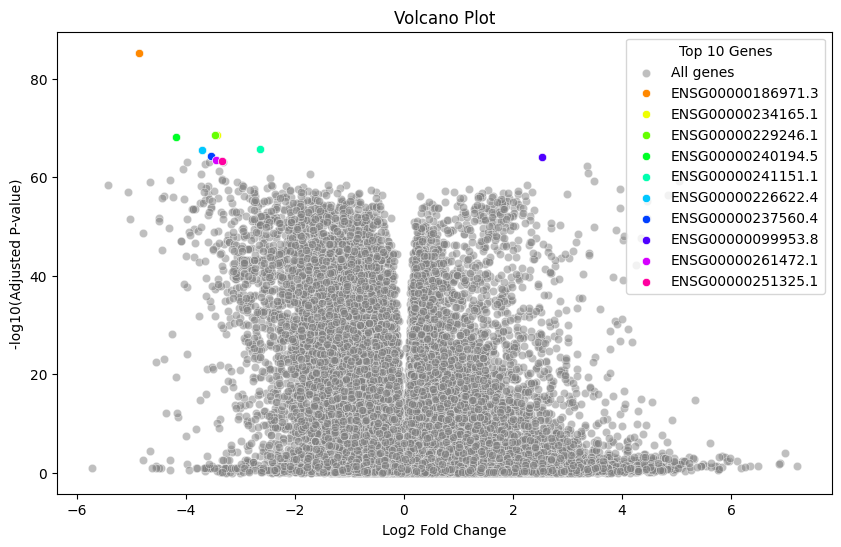

In [13]:
plt.figure(figsize=(10, 6))

# Since we want to give different colors for the top 10 genes
# define a color palette
colors = sns.color_palette('hsv', 10)

# Volcano plot for all genes
sns.scatterplot(data=results_df, x='Log2 Fold Change', y=-np.log10(results_df['Adjusted P-value']),
                color='grey', alpha=0.5, label='All genes')

# Volcano plot for only top 10 genes with colors and legends
x_values = top_10_genes['Log2 Fold Change']
y_values = -np.log10(top_10_genes['Adjusted P-value'])
for i, gene in enumerate(top_10_genes['Gene']):
    sns.scatterplot(x=[x_values[i]], y=[y_values[i]], color=colors[i], label=gene)

# Adding labels and title
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(Adjusted P-value)')
plt.title('Volcano Plot')

# Adding a legend for better readibility
plt.legend(title='Top 10 Genes')

plt.savefig('outputs/volcano_plot_with_legend.pdf')
plt.show()

# Step 4: Gene set enrichment analysis

In [24]:
import re
from gseapy import Biomart
bm = Biomart()

In [35]:
glist = list(top_10_genes['Gene']) 

# removing the version number after the dot(.)
queries = {'ensembl_gene_id': [re.sub(r'\.\d+', '', gene) for gene in glist]}
queries

{'ensembl_gene_id': ['ENSG00000186971',
  'ENSG00000234165',
  'ENSG00000229246',
  'ENSG00000240194',
  'ENSG00000241151',
  'ENSG00000226622',
  'ENSG00000237560',
  'ENSG00000099953',
  'ENSG00000261472',
  'ENSG00000251325']}

In [33]:
# mapping the gene_id with gene_names
results = bm.query(dataset='hsapiens_gene_ensembl',
                   attributes=['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'go_id'],
                   filters=queries)
results.head()

,ensembl_gene_id,external_gene_name,entrezgene_id,go_id
0,ENSG00000099953,MMP11,4320,NaN
1,ENSG00000099953,MMP11,4320,GO:0008270
2,ENSG00000099953,MMP11,4320,GO:0006508
3,ENSG00000099953,MMP11,4320,GO:0008237
4,ENSG00000099953,MMP11,4320,GO:0004222


**Plotting the result**

In [34]:
# simple plotting function
from gseapy import barplot, dotplot

- For KEGG pathways, visualize the enriched pathways.
- For GO-MF terms, visualize the enriched molecular functions.
- For GO-CC terms, visualize the enriched cellular components.
- For GO-BP terms, visualize the enriched biological processes.

In [77]:
# Step 2: Prepare the gene list for enrichment analysis
gene_list = queries['ensembl_gene_id']

# if you are only intrested in dataframe that enrichr returned, please set outdir=None
enr = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
                 gene_sets=['KEGG_2021_Yeast'],
                 organism='yeast', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

2024-04-21 12:28:14,706 [WARNING] Input library not found: KEGG_2021_Yeast. Skip


Exception: No GeneSets are valid !!! Check your gene_sets input.

In [76]:
enr.results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
